Found 720 files belonging to 2 classes.
Class Names: ['forge', 'real']
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resize_rescale_layer_4 (Resi (None, 256, 256, 3)       0         
_________________________________________________________________
data_augmentation_layer_4 (D (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________

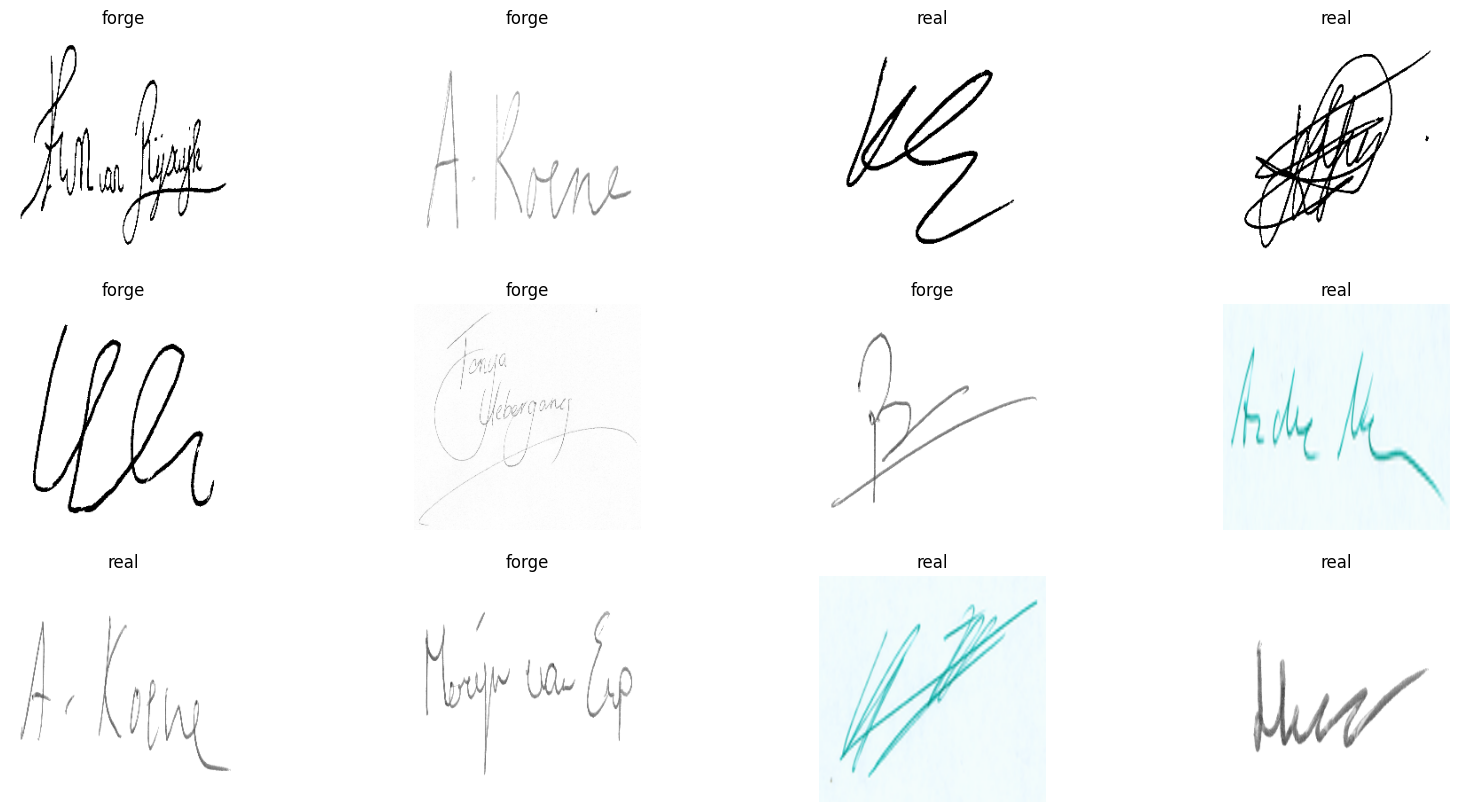

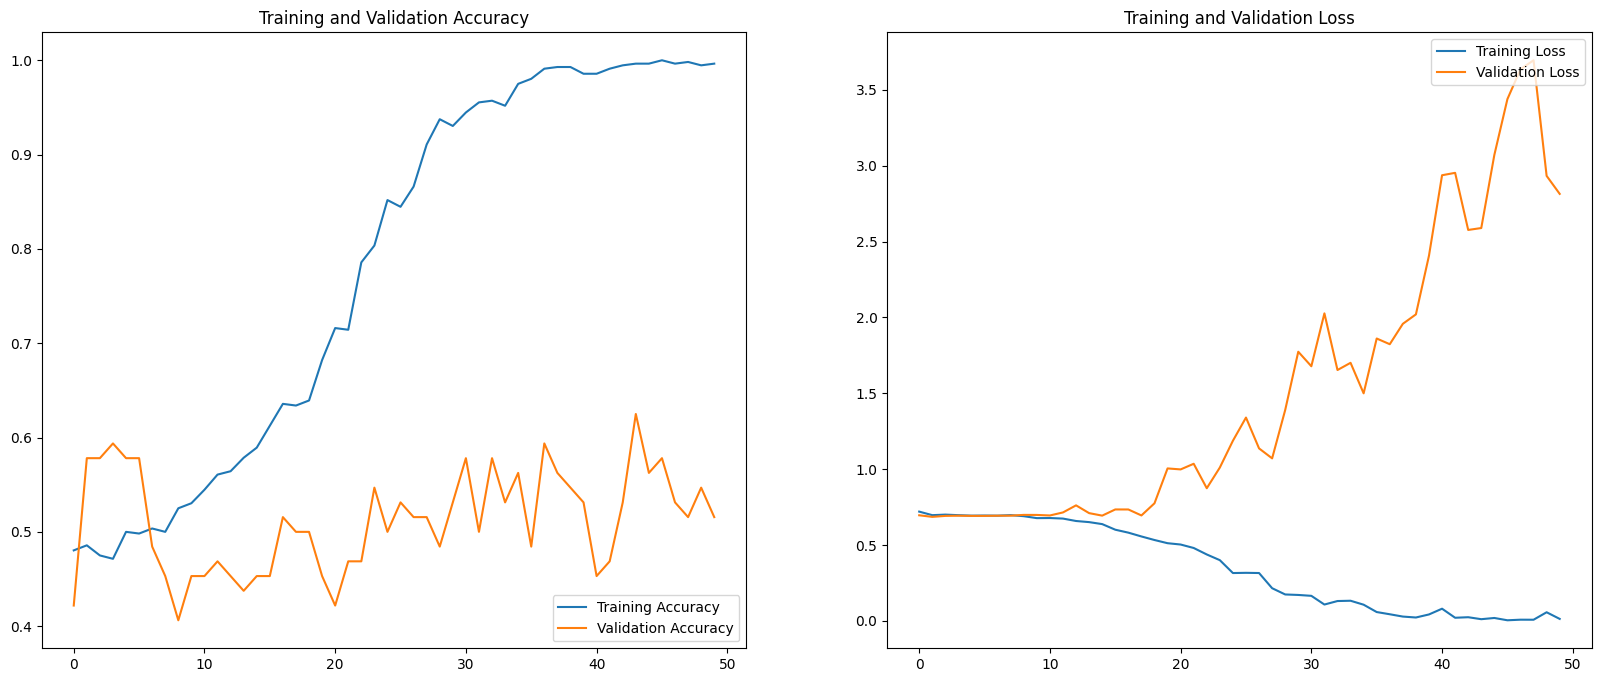

First image to predict
Actual label: forge
Predicted label: real


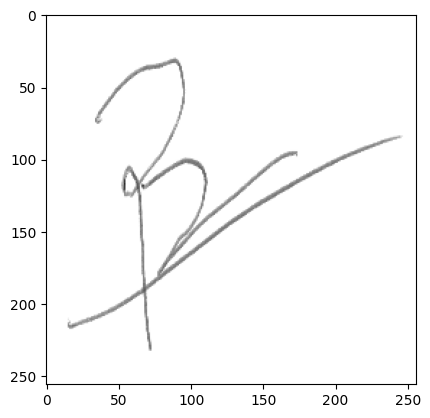

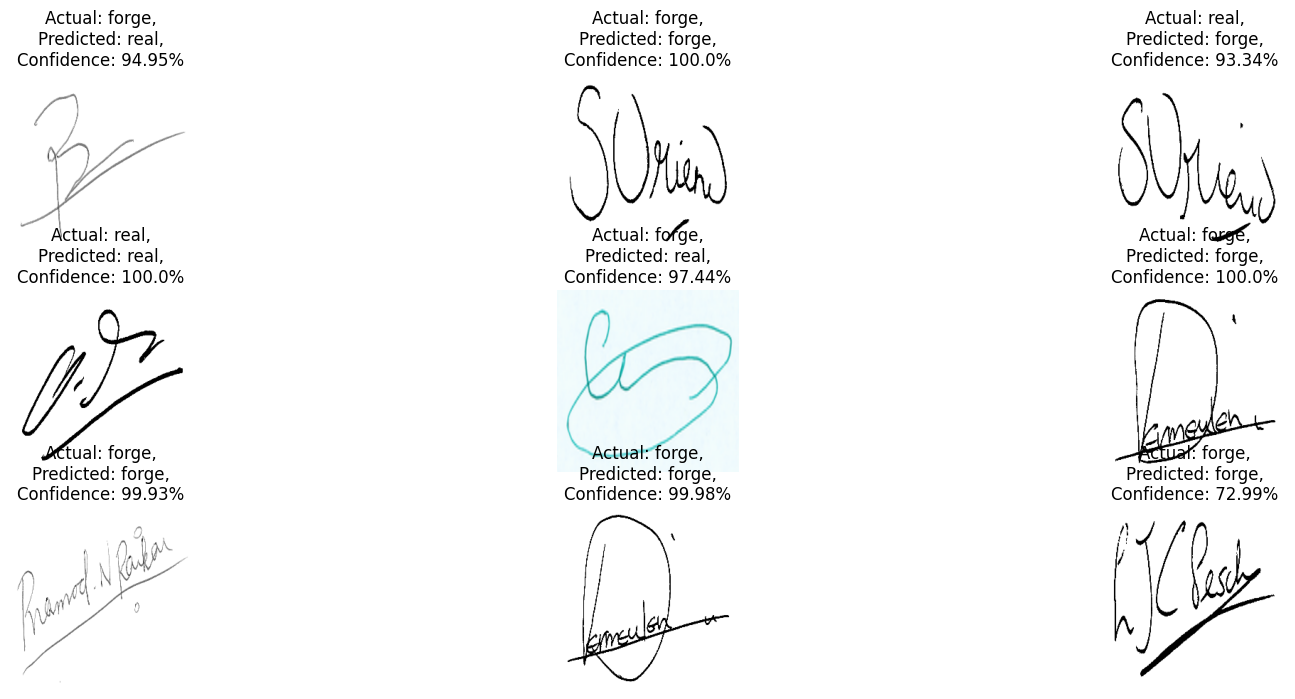

In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

# Set parameters
image_size = 256
batch_size = 32
channel = 3

# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset_Signature_Finals",
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

# Get class names
class_names = dataset.class_names
print("Class Names:", class_names)

# Display sample images
plt.figure(figsize=(20, 10))
for image_batch, label_batch in dataset.take(1):  
    for i in range(12):  
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# Split dataset into training, validation, and test sets
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partition(dataset)

# Optimize datasets for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Custom resizing and rescaling layer
class ResizeRescaleLayer(layers.Layer):
    def __init__(self, image_size):
        super(ResizeRescaleLayer, self).__init__()
        self.image_size = image_size

    def call(self, inputs):
        inputs = tf.image.resize(inputs, [self.image_size, self.image_size])
        return inputs / 255.0

    def get_config(self):
        config = super().get_config()
        config.update({"image_size": self.image_size})
        return config

# Data augmentation layer using tf.image functions
class DataAugmentationLayer(layers.Layer):
    def __init__(self):
        super(DataAugmentationLayer, self).__init__()

    def call(self, inputs, training=True):
        if training:
            inputs = tf.image.random_flip_left_right(inputs)
            inputs = tf.image.random_flip_up_down(inputs)
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))  # random 90-degree rotation
        return inputs

data_augmentation = DataAugmentationLayer()

# Define the model with explicit input_shape in an InputLayer
input_shape = (image_size, image_size, channel)
n_classes = len(class_names)

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),   # Explicitly add an InputLayer
    ResizeRescaleLayer(image_size),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Check model summary
model.summary()

# Save model
model.save('crnn_signature_verification_model.keras')

# Train the model
epochs = 50
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

# Evaluate the model on the test dataset
final_loss, final_accuracy = model.evaluate(test_ds)
print('Final loss: {:.2f}%'.format(final_loss * 100))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))

# Plot training history
acc_his = history.history['accuracy']
val_acc_his = history.history['val_accuracy']
loss_his = history.history['loss']
val_loss_his = history.history['val_loss']

plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_his, label='Training Accuracy')
plt.plot(range(epochs), val_acc_his, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
ax = plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss_his, label='Training Loss')
plt.plot(range(epochs), val_loss_his, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Make predictions on a test batch
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print('First image to predict')
    plt.imshow(first_image)
    print('Actual label:', class_names[first_label])
    batch_predictions = model.predict(image_batch)
    print('Predicted label:', class_names[np.argmax(batch_predictions[0])])

# Prediction function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Plot predictions
plt.figure(figsize=(20, 8))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}%')
        plt.axis('off')
plt.show()




In [ ]:
final_loss,final_accuracy=model.evaluate(test_ds)
print('Final loss:{:.2f}%'.format(final_loss*100))
print('Final Accuracy:{:.2f}%'.format(final_accuracy*100))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 738ms/step - accuracy: 0.5302 - loss: 0.6643
Final loss:67.37%
Final Accuracy:55.00%
